In [1]:
import duckdb
import pandas as pd

In [9]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

con = duckdb.connect()

# ============================================================================
# COMPLETE DISTRIBUTION COMPARISON QUERY
# ============================================================================

comparison_query = """
WITH full_stats AS (
    SELECT 
        'full' as dataset,
        
        -- Basic counts
        COUNT(*) as total_messages,
        COUNT(DISTINCT client_id) as unique_clients,
        COUNT(DISTINCT campaign_id) as unique_campaigns,
        COUNT(DISTINCT message_id) as unique_message_ids,
        
        -- Date range
        MIN(date) as min_date,
        MAX(date) as max_date,
        MIN(sent_at) as min_sent_at,
        MAX(sent_at) as max_sent_at,
        
        -- Channel distribution
        COUNT(DISTINCT channel) as unique_channels,
        
        -- Categorical distributions (will handle separately)
        COUNT(DISTINCT message_type) as unique_message_types,
        COUNT(DISTINCT category) as unique_categories,
        COUNT(DISTINCT platform) as unique_platforms,
        COUNT(DISTINCT email_provider) as unique_email_providers,
        COUNT(DISTINCT stream) as unique_streams,
        
        -- Engagement metrics (rates)
        AVG(CAST(is_opened AS FLOAT)) as open_rate,
        AVG(CAST(is_clicked AS FLOAT)) as click_rate,
        AVG(CAST(is_purchased AS FLOAT)) as purchase_rate,
        AVG(CAST(is_unsubscribed AS FLOAT)) as unsubscribe_rate,
        AVG(CAST(is_hard_bounced AS FLOAT)) as hard_bounce_rate,
        AVG(CAST(is_soft_bounced AS FLOAT)) as soft_bounce_rate,
        AVG(CAST(is_complained AS FLOAT)) as complaint_rate,
        AVG(CAST(is_blocked AS FLOAT)) as blocked_rate,
        
        -- Time to action metrics (in hours, for opened messages only)
        AVG(EPOCH(opened_first_time_at - sent_at) / 3600.0) as avg_hours_to_open,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY EPOCH(opened_first_time_at - sent_at) / 3600.0) as median_hours_to_open,
        AVG(EPOCH(clicked_first_time_at - sent_at) / 3600.0) as avg_hours_to_click,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY EPOCH(clicked_first_time_at - sent_at) / 3600.0) as median_hours_to_click,
        AVG(EPOCH(purchased_at - sent_at) / 3600.0) as avg_hours_to_purchase,
        
        -- Click-through rate (CTR) - clicks among opens
        SUM(CAST(is_clicked AS INT))::FLOAT / NULLIF(SUM(CAST(is_opened AS INT)), 0) as ctr_among_opens,
        
        -- Purchase conversion among clicks
        SUM(CAST(is_purchased AS INT))::FLOAT / NULLIF(SUM(CAST(is_clicked AS INT)), 0) as purchase_rate_among_clicks,
        
        -- Messages per client (calculated correctly)
        COUNT(*)::FLOAT / COUNT(DISTINCT client_id) as avg_messages_per_client,
        
    FROM read_csv_auto('data/messages.csv')
),
sample_stats AS (
    SELECT 
        'sample' as dataset,
        
        -- Basic counts
        COUNT(*) as total_messages,
        COUNT(DISTINCT client_id) as unique_clients,
        COUNT(DISTINCT campaign_id) as unique_campaigns,
        COUNT(DISTINCT message_id) as unique_message_ids,
        
        -- Date range
        MIN(date) as min_date,
        MAX(date) as max_date,
        MIN(sent_at) as min_sent_at,
        MAX(sent_at) as max_sent_at,
        
        -- Channel distribution
        COUNT(DISTINCT channel) as unique_channels,
        
        -- Categorical distributions
        COUNT(DISTINCT message_type) as unique_message_types,
        COUNT(DISTINCT category) as unique_categories,
        COUNT(DISTINCT platform) as unique_platforms,
        COUNT(DISTINCT email_provider) as unique_email_providers,
        COUNT(DISTINCT stream) as unique_streams,
        
        -- Engagement metrics (rates)
        AVG(CAST(is_opened AS FLOAT)) as open_rate,
        AVG(CAST(is_clicked AS FLOAT)) as click_rate,
        AVG(CAST(is_purchased AS FLOAT)) as purchase_rate,
        AVG(CAST(is_unsubscribed AS FLOAT)) as unsubscribe_rate,
        AVG(CAST(is_hard_bounced AS FLOAT)) as hard_bounce_rate,
        AVG(CAST(is_soft_bounced AS FLOAT)) as soft_bounce_rate,
        AVG(CAST(is_complained AS FLOAT)) as complaint_rate,
        AVG(CAST(is_blocked AS FLOAT)) as blocked_rate,
        
        -- Time to action metrics
        AVG(EPOCH(opened_first_time_at - sent_at) / 3600.0) as avg_hours_to_open,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY EPOCH(opened_first_time_at - sent_at) / 3600.0) as median_hours_to_open,
        AVG(EPOCH(clicked_first_time_at - sent_at) / 3600.0) as avg_hours_to_click,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY EPOCH(clicked_first_time_at - sent_at) / 3600.0) as median_hours_to_click,
        AVG(EPOCH(purchased_at - sent_at) / 3600.0) as avg_hours_to_purchase,
        
        -- Click-through rate
        SUM(CAST(is_clicked AS INT))::FLOAT / NULLIF(SUM(CAST(is_opened AS INT)), 0) as ctr_among_opens,
        
        -- Purchase conversion among clicks
        SUM(CAST(is_purchased AS INT))::FLOAT / NULLIF(SUM(CAST(is_clicked AS INT)), 0) as purchase_rate_among_clicks,
        
        -- Messages per client
        COUNT(*)::FLOAT / COUNT(DISTINCT client_id) as avg_messages_per_client,
        
    FROM read_parquet('data/messages_subset.parquet')
)
SELECT * FROM full_stats
UNION ALL
SELECT * FROM sample_stats
"""

# Execute and get summary stats
summary_df = con.execute(comparison_query).df()

# ============================================================================
# CATEGORICAL DISTRIBUTIONS
# ============================================================================

def get_categorical_distribution(column_name):
    query = f"""
    WITH full_dist AS (
        SELECT 
            'full' as dataset,
            {column_name},
            COUNT(*) as count,
            COUNT(*)::FLOAT / SUM(COUNT(*)) OVER () as percentage
        FROM read_csv_auto('data/messages.csv')
        WHERE {column_name} IS NOT NULL
        GROUP BY {column_name}
    ),
    sample_dist AS (
        SELECT 
            'sample' as dataset,
            {column_name},
            COUNT(*) as count,
            COUNT(*)::FLOAT / SUM(COUNT(*)) OVER () as percentage
        FROM read_parquet('data/messages_subset.parquet')
        WHERE {column_name} IS NOT NULL
        GROUP BY {column_name}
    )
    SELECT 
        COALESCE(f.{column_name}, s.{column_name}) as category,
        f.count as full_count,
        f.percentage as full_pct,
        s.count as sample_count,
        s.percentage as sample_pct,
        ABS(COALESCE(f.percentage, 0) - COALESCE(s.percentage, 0)) as pct_diff
    FROM full_dist f
    FULL OUTER JOIN sample_dist s ON f.{column_name} = s.{column_name}
    ORDER BY COALESCE(f.count, 0) DESC
    """
    return con.execute(query).df()

# Get distributions for all categorical columns
categorical_cols = [
    'message_type', 'channel', 'category', 'platform', 
    'email_provider', 'stream'
]

print("Getting categorical distributions...")
categorical_distributions = {}
for col in categorical_cols:
    print(f"  Processing {col}...")
    categorical_distributions[col] = get_categorical_distribution(col)

# ============================================================================
# TIME-BASED DISTRIBUTIONS
# ============================================================================

print("Getting time-based distributions...")
time_distribution_query = """
WITH full_time AS (
    SELECT 
        'full' as dataset,
        DATE_TRUNC('month', date) as month,
        COUNT(*) as message_count,
        AVG(CAST(is_opened AS FLOAT)) as open_rate,
        AVG(CAST(is_clicked AS FLOAT)) as click_rate,
        AVG(CAST(is_purchased AS FLOAT)) as purchase_rate
    FROM read_csv_auto('data/messages.csv')
    GROUP BY DATE_TRUNC('month', date)
),
sample_time AS (
    SELECT 
        'sample' as dataset,
        DATE_TRUNC('month', date) as month,
        COUNT(*) as message_count,
        AVG(CAST(is_opened AS FLOAT)) as open_rate,
        AVG(CAST(is_clicked AS FLOAT)) as click_rate,
        AVG(CAST(is_purchased AS FLOAT)) as purchase_rate
    FROM read_parquet('data/messages_subset.parquet')
    GROUP BY DATE_TRUNC('month', date)
)
SELECT 
    COALESCE(f.month, s.month) as month,
    f.message_count as full_count,
    s.message_count as sample_count,
    f.open_rate as full_open_rate,
    s.open_rate as sample_open_rate,
    f.click_rate as full_click_rate,
    s.click_rate as sample_click_rate,
    f.purchase_rate as full_purchase_rate,
    s.purchase_rate as sample_purchase_rate
FROM full_time f
FULL OUTER JOIN sample_time s ON f.month = s.month
ORDER BY month
"""

time_dist_df = con.execute(time_distribution_query).df()

# ============================================================================
# CAMPAIGN-LEVEL STATISTICS
# ============================================================================

print("Getting campaign-level statistics...")
campaign_stats_query = """
WITH full_campaign AS (
    SELECT 
        campaign_id,
        COUNT(*) as messages,
        AVG(CAST(is_opened AS FLOAT)) as open_rate,
        AVG(CAST(is_clicked AS FLOAT)) as click_rate,
        AVG(CAST(is_purchased AS FLOAT)) as purchase_rate
    FROM read_csv_auto('data/messages.csv')
    GROUP BY campaign_id
),
sample_campaign AS (
    SELECT 
        campaign_id,
        COUNT(*) as messages,
        AVG(CAST(is_opened AS FLOAT)) as open_rate,
        AVG(CAST(is_clicked AS FLOAT)) as click_rate,
        AVG(CAST(is_purchased AS FLOAT)) as purchase_rate
    FROM read_parquet('data/messages_subset.parquet')
    GROUP BY campaign_id
)
SELECT
    'full' as dataset,
    AVG(messages) as avg_messages_per_campaign,
    STDDEV(messages) as std_messages_per_campaign,
    AVG(open_rate) as avg_campaign_open_rate,
    AVG(click_rate) as avg_campaign_click_rate,
    AVG(purchase_rate) as avg_campaign_purchase_rate
FROM full_campaign
UNION ALL
SELECT
    'sample' as dataset,
    AVG(messages) as avg_messages_per_campaign,
    STDDEV(messages) as std_messages_per_campaign,
    AVG(open_rate) as avg_campaign_open_rate,
    AVG(click_rate) as avg_campaign_click_rate,
    AVG(purchase_rate) as avg_campaign_purchase_rate
FROM sample_campaign
"""

campaign_stats_df = con.execute(campaign_stats_query).df()


Getting categorical distributions...
  Processing message_type...
  Processing channel...
  Processing category...
  Processing platform...
  Processing email_provider...
  Processing stream...
Getting time-based distributions...
Getting campaign-level statistics...



Generating comparison report...
EMAIL CAMPAIGN DATA - SAMPLE VALIDATION REPORT

📊 BASIC STATISTICS
--------------------------------------------------------------------------------
Total Messages:        Full: 708,447,796  |  Sample: 20,916,395
Sampling Rate:         2.95%
Unique Clients:        Full: 16,860,044  |  Sample: 499,633
Unique Campaigns:      Full: 1,903  |  Sample: 1,807
Date Range:            Full: 2021-04-30 00:00:00 to 2023-04-23 00:00:00
                       Sample: 2021-04-30 00:00:00 to 2023-04-23 00:00:00
Avg Msgs per Client:   Full: 42.02  |  Sample: 41.86

📈 ENGAGEMENT METRICS COMPARISON
--------------------------------------------------------------------------------
✅ Open Rate                           Full:  18.62%  |  Sample:  18.62%  |  Diff:  0.00%
✅ Click Rate                          Full:   1.10%  |  Sample:   1.09%  |  Diff:  0.00%
✅ Purchase Rate                       Full:   0.03%  |  Sample:   0.03%  |  Diff:  0.00%
✅ CTR (among opens)              

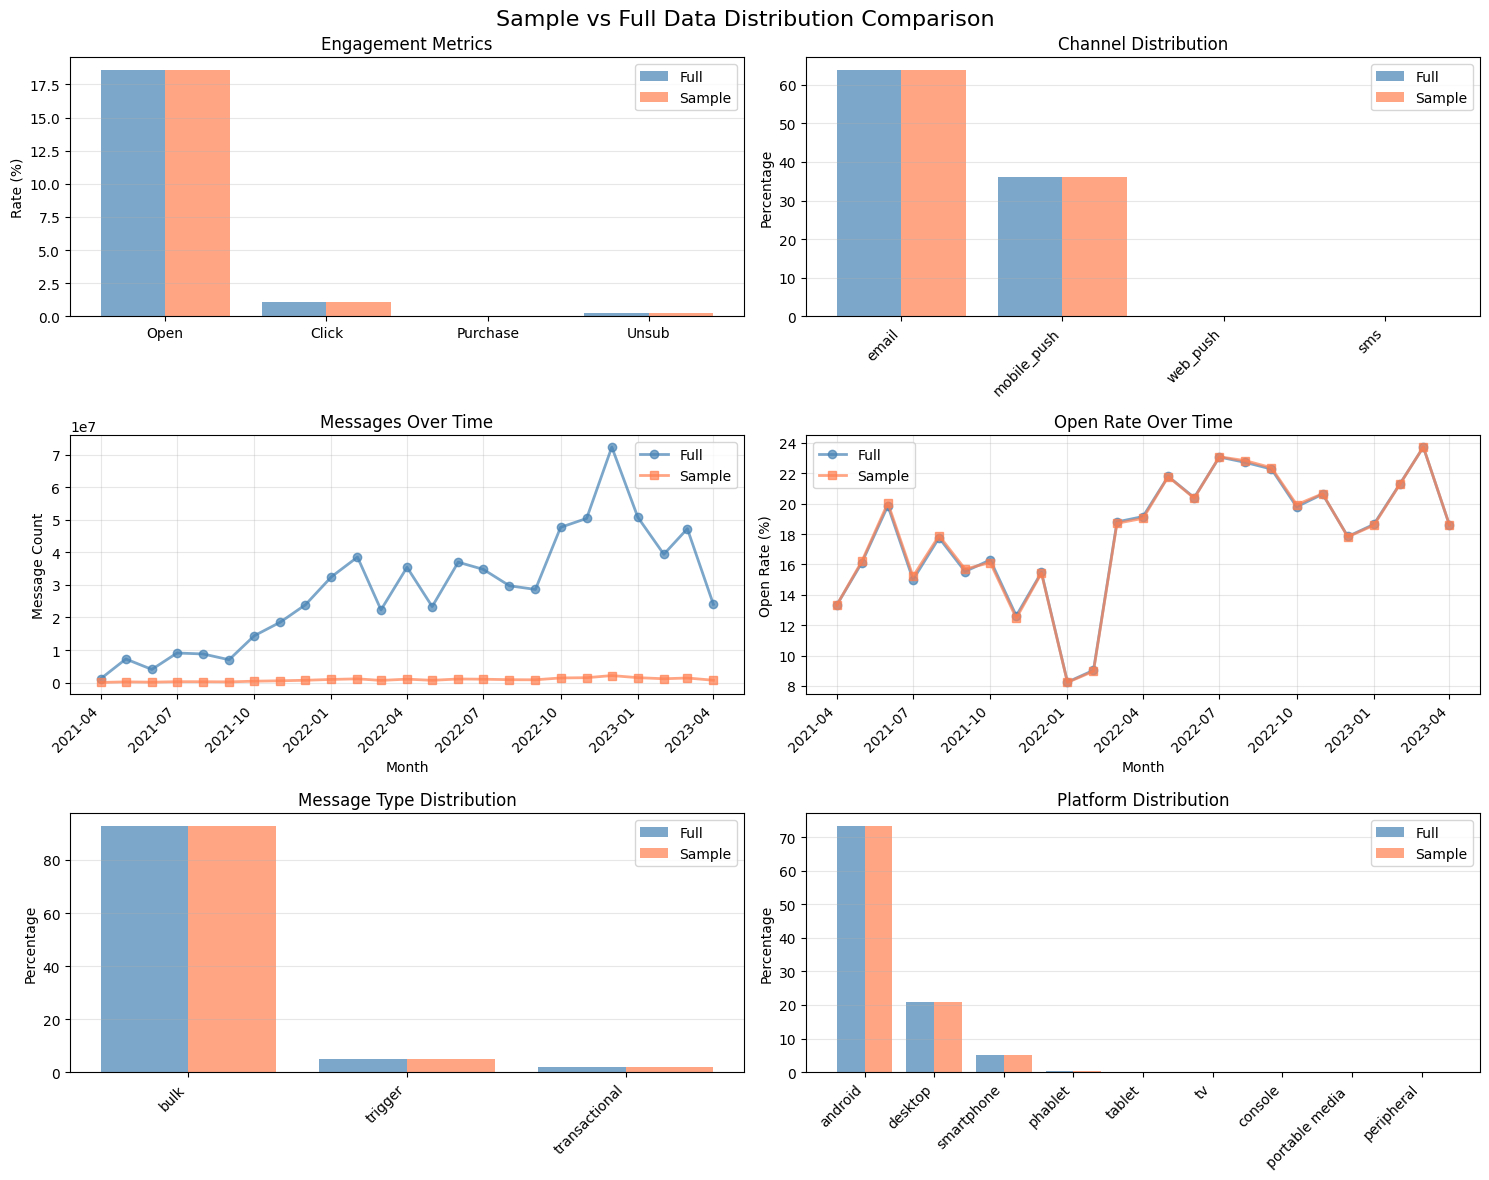

In [10]:

# ============================================================================
# PRINT COMPARISON REPORT
# ============================================================================

def print_comparison_report():
    print("=" * 80)
    print("EMAIL CAMPAIGN DATA - SAMPLE VALIDATION REPORT")
    print("=" * 80)
    
    # Basic stats
    print("\n📊 BASIC STATISTICS")
    print("-" * 80)
    full = summary_df[summary_df['dataset'] == 'full'].iloc[0]
    sample = summary_df[summary_df['dataset'] == 'sample'].iloc[0]
    
    print(f"Total Messages:        Full: {full['total_messages']:,}  |  Sample: {sample['total_messages']:,}")
    print(f"Sampling Rate:         {sample['total_messages']/full['total_messages']:.2%}")
    print(f"Unique Clients:        Full: {full['unique_clients']:,}  |  Sample: {sample['unique_clients']:,}")
    print(f"Unique Campaigns:      Full: {full['unique_campaigns']:,}  |  Sample: {sample['unique_campaigns']:,}")
    print(f"Date Range:            Full: {full['min_date']} to {full['max_date']}")
    print(f"                       Sample: {sample['min_date']} to {sample['max_date']}")
    print(f"Avg Msgs per Client:   Full: {full['avg_messages_per_client']:.2f}  |  Sample: {sample['avg_messages_per_client']:.2f}")
    
    # Engagement metrics
    print("\n📈 ENGAGEMENT METRICS COMPARISON")
    print("-" * 80)
    metrics = [
        ('Open Rate', 'open_rate'),
        ('Click Rate', 'click_rate'),
        ('Purchase Rate', 'purchase_rate'),
        ('CTR (among opens)', 'ctr_among_opens'),
        ('Purchase Rate (among clicks)', 'purchase_rate_among_clicks'),
        ('Unsubscribe Rate', 'unsubscribe_rate'),
        ('Hard Bounce Rate', 'hard_bounce_rate'),
        ('Soft Bounce Rate', 'soft_bounce_rate'),
        ('Complaint Rate', 'complaint_rate'),
    ]
    
    for metric_name, col in metrics:
        full_val = full[col] * 100 if pd.notna(full[col]) else 0
        sample_val = sample[col] * 100 if pd.notna(sample[col]) else 0
        diff = abs(full_val - sample_val)
        status = "✅" if diff < 0.5 else "⚠️" if diff < 2 else "❌"
        
        print(f"{status} {metric_name:35s} Full: {full_val:6.2f}%  |  Sample: {sample_val:6.2f}%  |  Diff: {diff:5.2f}%")
    
    # Time to action
    print("\n⏱️  TIME TO ACTION (hours)")
    print("-" * 80)
    time_metrics = [
        ('Avg Hours to Open', 'avg_hours_to_open'),
        ('Median Hours to Open', 'median_hours_to_open'),
        ('Avg Hours to Click', 'avg_hours_to_click'),
        ('Median Hours to Click', 'median_hours_to_click'),
        ('Avg Hours to Purchase', 'avg_hours_to_purchase'),
    ]
    
    for metric_name, col in time_metrics:
        full_val = full[col] if pd.notna(full[col]) else 0
        sample_val = sample[col] if pd.notna(sample[col]) else 0
        diff_pct = abs(full_val - sample_val) / full_val * 100 if full_val > 0 else 0
        status = "✅" if diff_pct < 5 else "⚠️" if diff_pct < 10 else "❌"
        
        print(f"{status} {metric_name:30s} Full: {full_val:7.2f}h  |  Sample: {sample_val:7.2f}h  |  Diff: {diff_pct:5.1f}%")
    
    # Campaign statistics
    print("\n📊 CAMPAIGN-LEVEL STATISTICS")
    print("-" * 80)
    camp_full = campaign_stats_df[campaign_stats_df['dataset'] == 'full'].iloc[0]
    camp_sample = campaign_stats_df[campaign_stats_df['dataset'] == 'sample'].iloc[0]
    
    print(f"Avg Messages per Campaign:  Full: {camp_full['avg_messages_per_campaign']:.1f}  |  Sample: {camp_sample['avg_messages_per_campaign']:.1f}")
    print(f"Std Messages per Campaign:  Full: {camp_full['std_messages_per_campaign']:.1f}  |  Sample: {camp_sample['std_messages_per_campaign']:.1f}")
    print(f"Avg Campaign Open Rate:     Full: {camp_full['avg_campaign_open_rate']*100:.2f}%  |  Sample: {camp_sample['avg_campaign_open_rate']*100:.2f}%")
    print(f"Avg Campaign Click Rate:    Full: {camp_full['avg_campaign_click_rate']*100:.2f}%  |  Sample: {camp_sample['avg_campaign_click_rate']*100:.2f}%")
    
    print("\n" + "=" * 80)
    print("✅ = Good match (<2% diff)  |  ⚠️ = Minor variance (2-5%)  |  ❌ = Significant difference (>5%)")
    print("=" * 80)

# Run the report
print("\nGenerating comparison report...")
print_comparison_report()

# ============================================================================
# OPTIONAL: CREATE VISUALIZATIONS
# ============================================================================

def create_visualizations():
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle('Sample vs Full Data Distribution Comparison', fontsize=16)
    
    full = summary_df[summary_df['dataset'] == 'full'].iloc[0]
    sample = summary_df[summary_df['dataset'] == 'sample'].iloc[0]
    
    # 1. Engagement metrics comparison
    ax = axes[0, 0]
    metrics = ['open_rate', 'click_rate', 'purchase_rate', 'unsubscribe_rate']
    metric_labels = ['Open', 'Click', 'Purchase', 'Unsub']
    x = range(len(metrics))
    
    full_vals = [full[m] * 100 if pd.notna(full[m]) else 0 for m in metrics]
    sample_vals = [sample[m] * 100 if pd.notna(sample[m]) else 0 for m in metrics]
    
    ax.bar([i - 0.2 for i in x], full_vals, width=0.4, label='Full', alpha=0.7, color='steelblue')
    ax.bar([i + 0.2 for i in x], sample_vals, width=0.4, label='Sample', alpha=0.7, color='coral')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.set_ylabel('Rate (%)')
    ax.set_title('Engagement Metrics')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # 2. Channel distribution
    ax = axes[0, 1]
    channel_dist = categorical_distributions['channel']
    if len(channel_dist) > 0:
        x = range(len(channel_dist))
        full_pcts = [v * 100 if pd.notna(v) else 0 for v in channel_dist['full_pct']]
        sample_pcts = [v * 100 if pd.notna(v) else 0 for v in channel_dist['sample_pct']]
        
        ax.bar([i - 0.2 for i in x], full_pcts, width=0.4, label='Full', alpha=0.7, color='steelblue')
        ax.bar([i + 0.2 for i in x], sample_pcts, width=0.4, label='Sample', alpha=0.7, color='coral')
        ax.set_xticks(x)
        ax.set_xticklabels([str(c)[:15] for c in channel_dist['category']], rotation=45, ha='right')
        ax.set_ylabel('Percentage')
        ax.set_title('Channel Distribution')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    # 3. Time-based distribution
    ax = axes[1, 0]
    time_dist_df_sorted = time_dist_df.sort_values('month')
    ax.plot(time_dist_df_sorted['month'], time_dist_df_sorted['full_count'], 
            marker='o', label='Full', alpha=0.7, linewidth=2, color='steelblue')
    ax.plot(time_dist_df_sorted['month'], time_dist_df_sorted['sample_count'], 
            marker='s', label='Sample', alpha=0.7, linewidth=2, color='coral')
    ax.set_xlabel('Month')
    ax.set_ylabel('Message Count')
    ax.set_title('Messages Over Time')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 4. Open rate over time
    ax = axes[1, 1]
    full_open = [v * 100 if pd.notna(v) else 0 for v in time_dist_df_sorted['full_open_rate']]
    sample_open = [v * 100 if pd.notna(v) else 0 for v in time_dist_df_sorted['sample_open_rate']]
    
    ax.plot(time_dist_df_sorted['month'], full_open, 
            marker='o', label='Full', alpha=0.7, linewidth=2, color='steelblue')
    ax.plot(time_dist_df_sorted['month'], sample_open, 
            marker='s', label='Sample', alpha=0.7, linewidth=2, color='coral')
    ax.set_xlabel('Month')
    ax.set_ylabel('Open Rate (%)')
    ax.set_title('Open Rate Over Time')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 5. Message type distribution
    ax = axes[2, 0]
    msg_type_dist = categorical_distributions['message_type']
    if len(msg_type_dist) > 0:
        x = range(len(msg_type_dist))
        full_pcts = [v * 100 if pd.notna(v) else 0 for v in msg_type_dist['full_pct']]
        sample_pcts = [v * 100 if pd.notna(v) else 0 for v in msg_type_dist['sample_pct']]
        
        ax.bar([i - 0.2 for i in x], full_pcts, width=0.4, label='Full', alpha=0.7, color='steelblue')
        ax.bar([i + 0.2 for i in x], sample_pcts, width=0.4, label='Sample', alpha=0.7, color='coral')
        ax.set_xticks(x)
        ax.set_xticklabels([str(c)[:15] for c in msg_type_dist['category']], rotation=45, ha='right')
        ax.set_ylabel('Percentage')
        ax.set_title('Message Type Distribution')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    # 6. Platform distribution
    ax = axes[2, 1]
    platform_dist = categorical_distributions['platform']
    if len(platform_dist) > 0:
        x = range(len(platform_dist))
        full_pcts = [v * 100 if pd.notna(v) else 0 for v in platform_dist['full_pct']]
        sample_pcts = [v * 100 if pd.notna(v) else 0 for v in platform_dist['sample_pct']]
        
        ax.bar([i - 0.2 for i in x], full_pcts, width=0.4, label='Full', alpha=0.7, color='steelblue')
        ax.bar([i + 0.2 for i in x], sample_pcts, width=0.4, label='Sample', alpha=0.7, color='coral')
        ax.set_xticks(x)
        ax.set_xticklabels([str(c)[:15] for c in platform_dist['category']], rotation=45, ha='right')
        ax.set_ylabel('Percentage')
        ax.set_title('Platform Distribution')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sample_validation_report.png', dpi=150, bbox_inches='tight')
    print("\n📊 Visualization saved to 'sample_validation_report.png'")

# Create visualizations
print("\nCreating visualizations...")
create_visualizations()

print("\n✅ Validation complete!")


===== 🔍 OVERALL SUMMARY COMPARISON =====



dataset,full,sample,abs_diff,rel_diff_%
total_messages,7.084478e+08,2.091640e+07,-6.875314e+08,-97.048
unique_clients,1.686004e+07,4.996330e+05,-1.636041e+07,-97.037
unique_campaigns,1.903000e+03,1.807000e+03,-9.600000e+01,-5.045
unique_message_ids,7.084478e+08,2.091640e+07,-6.875314e+08,-97.048
unique_channels,4.000000e+00,4.000000e+00,0.000000e+00,0.000
unique_message_types,3.000000e+00,3.000000e+00,0.000000e+00,0.000
unique_categories,0.000000e+00,0.000000e+00,0.000000e+00,NaN
unique_platforms,9.000000e+00,6.000000e+00,-3.000000e+00,-33.333
unique_email_providers,2.170000e+02,1.910000e+02,-2.600000e+01,-11.982
unique_streams,3.000000e+00,3.000000e+00,0.000000e+00,0.000


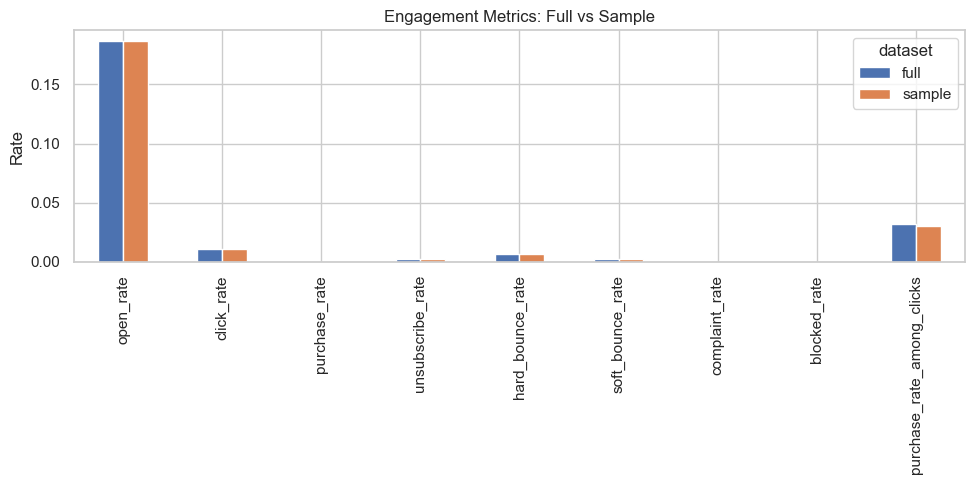

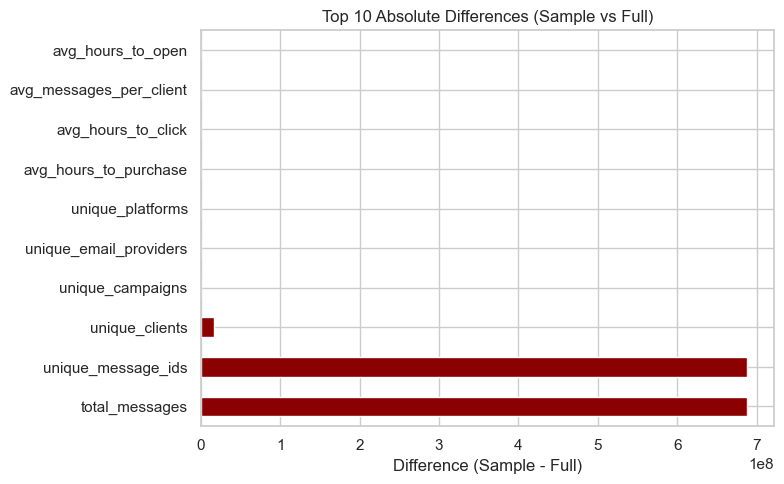


===== 🧭 CATEGORICAL DISTRIBUTIONS =====

→ message_type


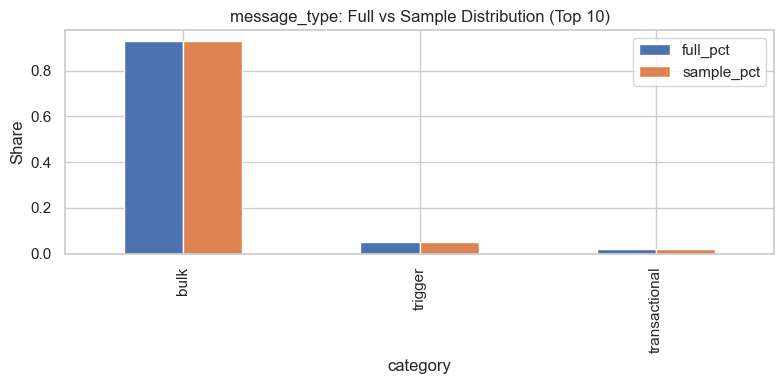

→ channel


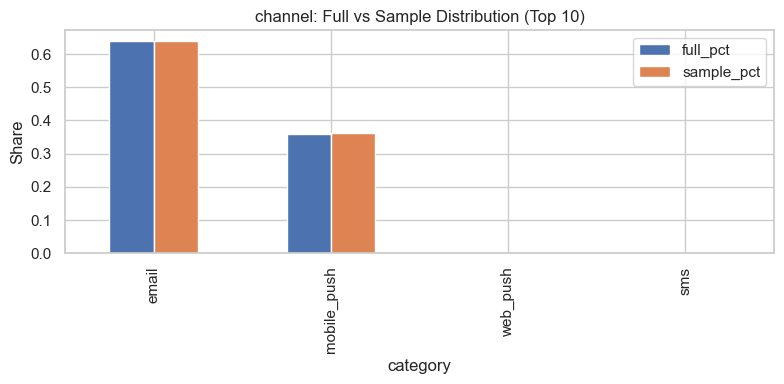

→ platform


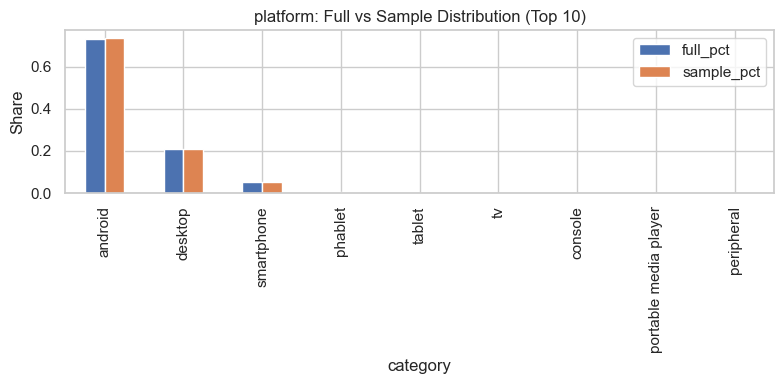

→ email_provider


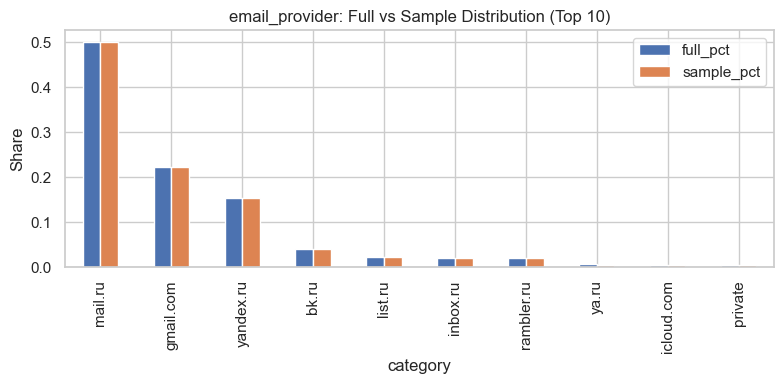

→ stream


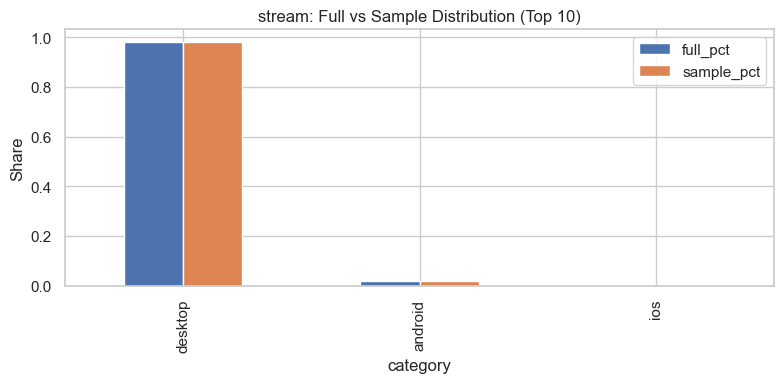


Average representativeness gap by category type:



,column,avg_abs_diff_%,max_abs_diff_%
0,message_type,0.060,0.090
2,platform,0.048,0.196
1,channel,0.048,0.095
4,stream,0.002,0.004
3,email_provider,0.002,0.080



===== 🕒 TEMPORAL EVOLUTION =====



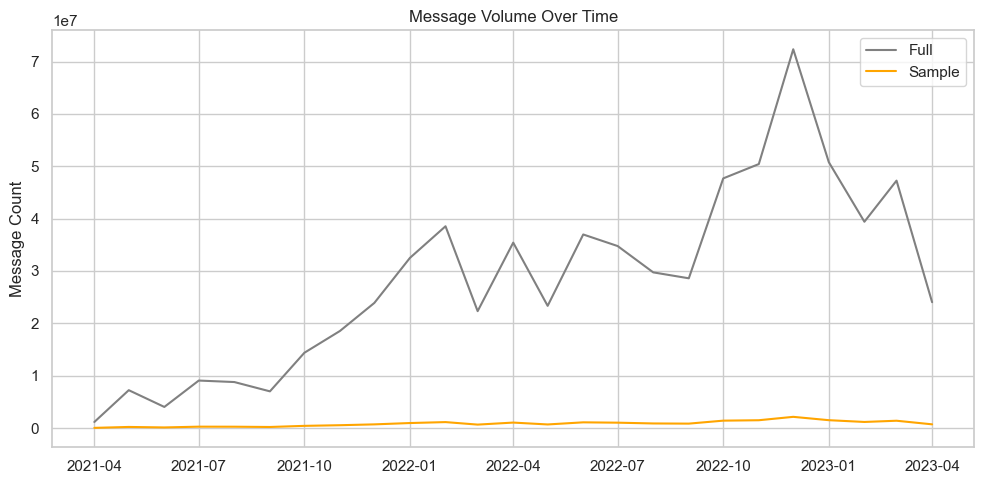

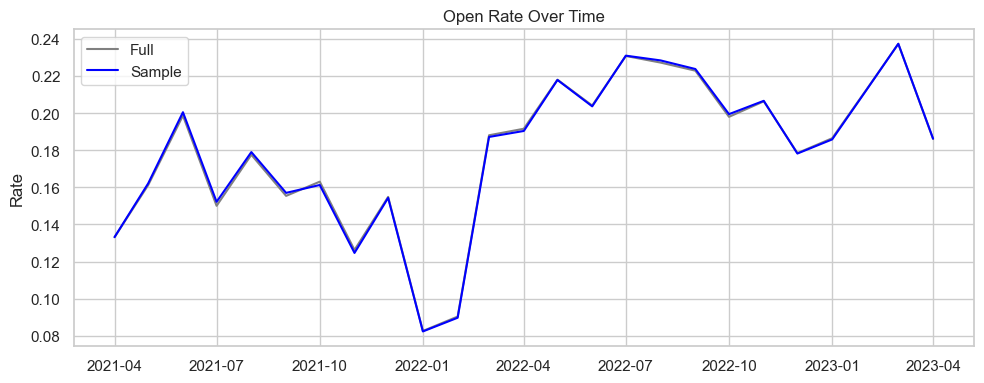

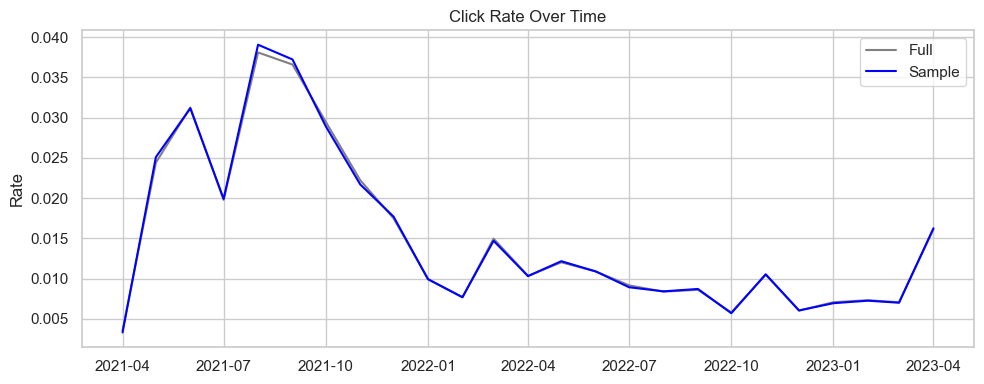

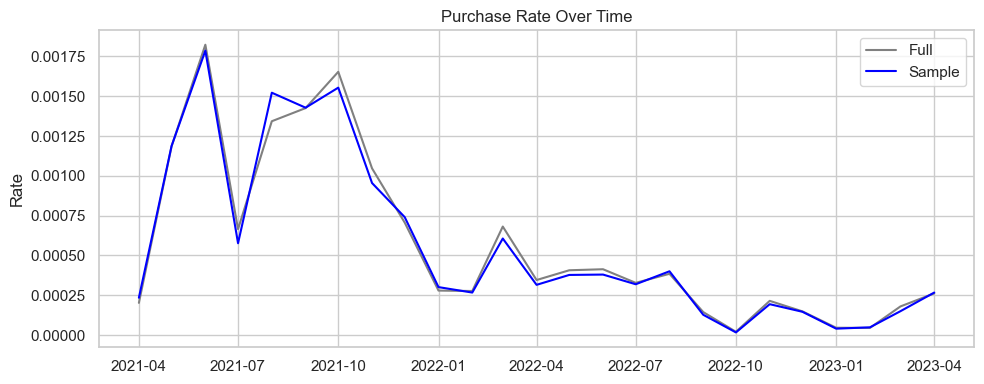

Temporal correlation (open rate, full vs sample): 1.000

===== 🎯 CAMPAIGN-LEVEL METRICS =====



dataset,full,sample,abs_diff,rel_diff_%
avg_messages_per_campaign,372279.451,11575.205,-360704.247,-96.891
std_messages_per_campaign,864942.987,26027.254,-838915.733,-96.991
avg_campaign_open_rate,0.403,0.399,-0.004,-0.981
avg_campaign_click_rate,0.027,0.024,-0.003,-11.790
avg_campaign_purchase_rate,0.001,0.001,-0.000,-28.794


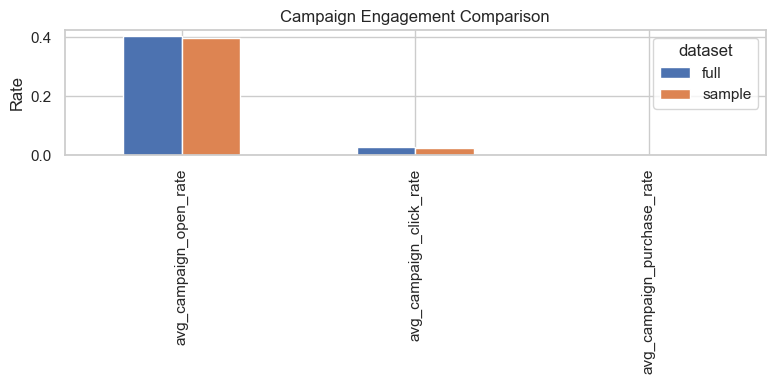


===== 🧩 SUMMARY INSIGHTS =====

✅ Median engagement metric deviation: ±0.74%
✅ Temporal correlation of open rates: 1.00
✅ Average categorical deviation: 0.03%
✅ Campaign-level median deviation: ±28.79%

If large deviations exist in specific categories, consider stratified resampling or weighted adjustments.


In [16]:
# ================================================================
# 📊 VALIDATION & REPRESENTATIVENESS ANALYSIS
# ================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ================================================================
# 1️⃣ SUMMARY METRICS COMPARISON
# ================================================================

def analyze_summary_stats(summary_df):
    """
    Compare key numeric KPIs between full and sample datasets.
    """
    # ✅ Keep only numeric columns to avoid timedelta/string division errors
    numeric_cols = summary_df.select_dtypes(include=["number"]).columns.tolist()
    if "dataset" in summary_df.columns:
        df = summary_df[["dataset"] + numeric_cols].set_index("dataset").T
    else:
        raise ValueError("summary_df must contain a 'dataset' column (values: full, sample)")

    # Compute absolute & relative differences
    df["abs_diff"] = df["sample"] - df["full"]
    df["rel_diff_%"] = 100 * df["abs_diff"] / df["full"]

    print("\n===== 🔍 OVERALL SUMMARY COMPARISON =====\n")
    display(df.round(3))

    # Plot engagement rate differences
    engagement_cols = [c for c in df.index if "rate" in c]
    if engagement_cols:
        plot_df = df.loc[engagement_cols, ["full", "sample"]]
        plot_df.plot(kind="bar", figsize=(10, 5), title="Engagement Metrics: Full vs Sample")
        plt.ylabel("Rate")
        plt.tight_layout()
        plt.show()

    # Plot absolute differences
    df["abs_diff"].abs().sort_values(ascending=False).head(10).plot(
        kind="barh", color="darkred", figsize=(8, 5)
    )
    plt.title("Top 10 Absolute Differences (Sample vs Full)")
    plt.xlabel("Difference (Sample - Full)")
    plt.tight_layout()
    plt.show()

    return df


# ================================================================
# 2️⃣ CATEGORICAL DISTRIBUTIONS
# ================================================================

def plot_categorical_distributions(categorical_distributions):
    """
    Compare category-level shares between full and sample datasets.
    """
    print("\n===== 🧭 CATEGORICAL DISTRIBUTIONS =====\n")
    results = []

    for col, dist_df in categorical_distributions.items():
        if col == 'category':
            continue  # Skip 'category' to avoid no index error
        print(f"→ {col}")
        dist_df = dist_df.copy()
        if "pct_diff" not in dist_df.columns:
            raise ValueError(f"Column 'pct_diff' not found in categorical_distributions[{col}]")

        dist_df["pct_diff_%"] = 100 * dist_df["pct_diff"]
        results.append({
            "column": col,
            "avg_abs_diff_%": dist_df["pct_diff_%"].abs().mean(),
            "max_abs_diff_%": dist_df["pct_diff_%"].abs().max()
        })

        top_cats = dist_df.head(10)
        top_cats.plot(
            x="category",
            y=["full_pct", "sample_pct"],
            kind="bar",
            figsize=(8, 4),
            title=f"{col}: Full vs Sample Distribution (Top 10)"
        )
        plt.ylabel("Share")
        plt.tight_layout()
        plt.show()

    diff_summary = pd.DataFrame(results).sort_values("avg_abs_diff_%", ascending=False)
    print("\nAverage representativeness gap by category type:\n")
    display(diff_summary.round(3))

    return diff_summary


# ================================================================
# 3️⃣ TEMPORAL DISTRIBUTIONS
# ================================================================

def plot_time_distributions(time_dist_df):
    """
    Compare temporal evolution of engagement metrics (monthly).
    """
    print("\n===== 🕒 TEMPORAL EVOLUTION =====\n")

    plt.figure(figsize=(10, 5))
    plt.plot(time_dist_df["month"], time_dist_df["full_count"], label="Full", color="gray")
    plt.plot(time_dist_df["month"], time_dist_df["sample_count"], label="Sample", color="orange")
    plt.title("Message Volume Over Time")
    plt.ylabel("Message Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    for metric in ["open_rate", "click_rate", "purchase_rate"]:
        full_col = f"full_{metric}"
        sample_col = f"sample_{metric}"
        if full_col in time_dist_df.columns and sample_col in time_dist_df.columns:
            plt.figure(figsize=(10, 4))
            plt.plot(time_dist_df["month"], time_dist_df[full_col], label="Full", color="gray")
            plt.plot(time_dist_df["month"], time_dist_df[sample_col], label="Sample", color="blue")
            plt.title(f"{metric.replace('_', ' ').title()} Over Time")
            plt.ylabel("Rate")
            plt.legend()
            plt.tight_layout()
            plt.show()

    # Correlation in open rates
    if {"full_open_rate", "sample_open_rate"} <= set(time_dist_df.columns):
        corr = time_dist_df[["full_open_rate", "sample_open_rate"]].corr().iloc[0, 1]
        print(f"Temporal correlation (open rate, full vs sample): {corr:.3f}")
        return corr
    else:
        print("Open rate columns missing for correlation computation.")
        return None


# ================================================================
# 4️⃣ CAMPAIGN-LEVEL STATISTICS
# ================================================================

def analyze_campaign_stats(campaign_stats_df):
    """
    Compare campaign-level averages (open/click/purchase rates).
    """
    numeric_cols = campaign_stats_df.select_dtypes(include=["number"]).columns.tolist()
    df = campaign_stats_df[["dataset"] + numeric_cols].set_index("dataset").T
    df["abs_diff"] = df["sample"] - df["full"]
    df["rel_diff_%"] = 100 * df["abs_diff"] / df["full"]

    print("\n===== 🎯 CAMPAIGN-LEVEL METRICS =====\n")
    display(df.round(3))

    plot_cols = [c for c in df.index if "rate" in c]
    if plot_cols:
        df.loc[plot_cols, ["full", "sample"]].plot(kind="bar", figsize=(8, 4))
        plt.title("Campaign Engagement Comparison")
        plt.ylabel("Rate")
        plt.tight_layout()
        plt.show()

    return df


# ================================================================
# 5️⃣ SUMMARY INSIGHTS
# ================================================================

def summarize_findings(summary_comparison_df, cat_diff_summary, temporal_corr, campaign_diff_df):
    print("\n===== 🧩 SUMMARY INSIGHTS =====\n")
    print(f"✅ Median engagement metric deviation: ±{summary_comparison_df['rel_diff_%'].abs().median():.2f}%")
    if temporal_corr is not None:
        print(f"✅ Temporal correlation of open rates: {temporal_corr:.2f}")
    print(f"✅ Average categorical deviation: {cat_diff_summary['avg_abs_diff_%'].mean():.2f}%")
    print(f"✅ Campaign-level median deviation: ±{campaign_diff_df['rel_diff_%'].abs().median():.2f}%")
    print("\nIf large deviations exist in specific categories, consider stratified resampling or weighted adjustments.")


# ================================================================
# 🚀 RUN ANALYSIS
# ================================================================

summary_comparison_df = analyze_summary_stats(summary_df)
cat_diff_summary = plot_categorical_distributions(categorical_distributions)
temporal_corr = plot_time_distributions(time_dist_df)
campaign_diff_df = analyze_campaign_stats(campaign_stats_df)
summarize_findings(summary_comparison_df, cat_diff_summary, temporal_corr, campaign_diff_df)
